In [1]:
# Working directory
import os
os.chdir ('E:/NLP/RNN/')

In [3]:
# Modules import
import numpy as np
import pandas as pd
import transformers
import tokenization
import torch
import torch.cuda
from transformers import EarlyStoppingCallback, IntervalStrategy, EvalPrediction
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer, TrainingArguments, BertForPreTraining
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import evaluate
from transformers import EvalPrediction
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [4]:
# Train dataset preprocessing

raw_train = pd.read_csv('train.csv')

raw_train[raw_train['Sentiment'].isnull()]  
raw_train = raw_train = raw_train.dropna() # Deleting empty strings

voc = {'Neutral':0,'Positive':1,'Negative':2, 'Extremely Positive':3, 'Extremely Negative':4}

raw_train['Sentiment'] = raw_train['Sentiment'].astype("category")
raw_train['Sentiment'] = raw_train['Sentiment'].apply(lambda x: voc[x])  # Converting categories to numbers

train_ds, valid_ds = train_test_split(raw_train, test_size=0.2, random_state=9) # Random splitting  of train sampling to train and validation samplings

train_ds.to_csv(f'train_ds.csv', index=None, header=False)
valid_ds.to_csv(f'valid_ds.csv', index=None, header=False)

# Test dataset
test = pd.read_csv('test.csv')
test.to_csv(f'test_ds.csv', index=None, header=False)
test_ds = test['Text']
test_dataset_X = load_dataset('csv', data_files={'test': 'test_ds.csv'}, column_names=['text'], delimiter=',')

#Training dataset
dataset = load_dataset('csv', data_files={'train': 'train_ds.csv','test':'valid_ds.csv'}, column_names=['text','labels'], delimiter=',')
dataset = dataset.remove_columns('__index_level_0__')
dataset

labels = dataset['train']['labels']
labels_list = list(set(labels))

Extracting data files: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 36.16it/s]
Generating test split: 3798 examples [00:00, 92207.58 examples/s]
Extracting data files: 100%|████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 133.49it/s]
Generating train split: 32924 examples [00:00, 289009.90 examples/s]
Generating test split: 8231 examples [00:00, 304774.37 examples/s]


In [5]:
# Accessory datasets

# Text training dataset
train_dataset = train_ds['Text']
train_dataset.to_csv(f'train_check_ds.csv', index=None, header=False)
train_dataset_X = load_dataset('csv', data_files={'train': 'train_check_ds.csv'}, column_names=['text'], delimiter=',')

# Text validation dataset
valid_dataset = valid_ds['Text']
valid_dataset.to_csv(f'valid_check_ds.csv', index=None, header=False)
valid_dataset_X = load_dataset('csv', data_files={'valid': 'valid_check_ds.csv'}, column_names=['text'], delimiter=',')

Extracting data files: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 148.84it/s]
Generating train split: 32924 examples [00:00, 348797.00 examples/s]
Extracting data files: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 141.60it/s]
Generating valid split: 8231 examples [00:00, 310950.83 examples/s]


In [7]:
# Model construction

model_id = 'bert-base-uncased' # Basic model
tokenizer  = AutoTokenizer.from_pretrained(model_id)

def tokenize(examples):
    """ Tokenization of the whole input"""
    return tokenizer(examples['text'], padding='max_length', max_length=128, truncation=True)

tokenizer_data = dataset.map(tokenize, batched=True)
tokenizer_data

Map: 100%|███████████████████████████████████████████████████████████████| 8231/8231 [00:00<00:00, 11132.58 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 32924
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8231
    })
})

In [8]:
# Train and validation labels
train_Y_labels = tokenizer_data['train']['labels']
valid_Y_labels = tokenizer_data['test']['labels']

In [9]:
labels = dataset['train']['labels']
num_labels = len(list(set(labels)))
num_labels

5

In [10]:
data_collator = DataCollatorWithPadding(tokenizer)

In [13]:
# Training arguments
train_args = TrainingArguments(
    output_dir ='./Models',
    overwrite_output_dir = True,
        # do_eval = True,
        logging_steps = 500,
        # eval_steps = 500,
        # evaluation_strategy = "steps",
        learning_rate=3e-6,
        save_total_limit = 20,
        lr_scheduler_type='linear',
        warmup_steps = 0,
        warmup_ratio = 0.1,
        num_train_epochs=1,
        label_names = labels_list,
        logging_dir='./output/logs',
    )

In [11]:
# LOADING MODEL FROM CHECKPOINT
model = AutoModelForSequenceClassification.from_pretrained('./Models/checkpoint-4000')
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [12]:
# Function estimating accuracy

def predicted_labels(trainer, x):
    """Predicts labels for a given text array"""
    valid_predicts = trainer.predict(test_dataset=x)
    from scipy.special import softmax
    predictions = valid_predicts.predictions
    probs = softmax(predictions, axis=-1)
    predicted_labels = np.argmax(probs, axis=-1)
    return predicted_labels


def making_predictions(trainer, dataset_X, dataset_type):
    """ Makes predicts for dataset"""

    tokenizer_data = dataset_X.map(tokenize, batched=True)
    x_predicted_labels = predicted_labels(trainer, tokenizer_data[dataset_type])
    return x_predicted_labels

def accuracy_check(x,y):
    """Accuracy calculation"""
    lst_common = []
    if len(x) == len(y):
        for i in range(len(x)):
            if x[i]==y[i]:
                lst_common.append(x[i])
            accuracy = len(lst_common)/len(x)
    else:
        print('Different length of datasets')
    return accuracy

In [13]:
def model_estimation(model, num_iter):
    """ Еrains the model and estimates training and validation accuracy for a series of points"""
    train_accuracy_lst=[]
    valid_accuracy_lst=[]
    for i in range(num_iter):
        trainer = Trainer(model=model, 
                  args=train_args, 
                  data_collator = data_collator, 
                  train_dataset = tokenizer_data['train'],
                  eval_dataset = tokenizer_data['test'],)
        trainer.train()
        train_predicted_labels = making_predictions(trainer, train_dataset_X, 'train')
        valid_predicted_labels = making_predictions(trainer, valid_dataset_X, 'valid')
        train_accuracy = accuracy_check(train_predicted_labels, train_Y_labels)
        train_accuracy_lst.append(train_accuracy)
        valid_accuracy = accuracy_check(valid_predicted_labels,valid_Y_labels)
        print("Epoch number: ", i, "  Train accuracy: ", train_accuracy, "  Valid accuracy: ",valid_accuracy)
        valid_accuracy_lst.append(valid_accuracy)
        model = AutoModelForSequenceClassification.from_pretrained('./Models/checkpoint-4000')
    return train_accuracy_lst, valid_accuracy_lst

In [13]:
train_accuracy_lst, valid_accuracy_lst = model_estimation(model, num_iter = 20)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,1.593600
1000,1.437200
1500,1.274100
2000,1.183000
2500,1.119100
3000,1.066500
3500,1.041700
4000,1.021600


Map: 100%|██████████████████████████████████████████████████████████████| 32924/32924 [00:03<00:00, 8774.46 examples/s]


Map: 100%|████████████████████████████████████████████████████████████████| 8231/8231 [00:00<00:00, 9859.32 examples/s]


Epoch number:  0   Train accuracy:  0.6001093427287085   Valid accuracy:  0.5825537601749484


Step,Training Loss
500,1.012400
1000,0.955000
1500,0.906200
2000,0.871900
2500,0.837700
3000,0.827100
3500,0.825100
4000,0.829200


Epoch number:  1   Train accuracy:  0.7058984327542218   Valid accuracy:  0.6665046774389503


Step,Training Loss
500,0.756600
1000,0.688500
1500,0.670700
2000,0.654600
2500,0.658400
3000,0.678600
3500,0.695000
4000,0.726300


Epoch number:  2   Train accuracy:  0.7706839995140323   Valid accuracy:  0.719475154902199


Step,Training Loss
500,0.581500
1000,0.469100
1500,0.478200
2000,0.494100
2500,0.529000
3000,0.581400
3500,0.618200
4000,0.679800


Epoch number:  3   Train accuracy:  0.8070708297898189   Valid accuracy:  0.7415866844854817


Step,Training Loss
500,0.452800
1000,0.325800
1500,0.347800
2000,0.374400
2500,0.451000
3000,0.521000
3500,0.584100
4000,0.666800


Epoch number:  4   Train accuracy:  0.8268740128781435   Valid accuracy:  0.7500911189405904


Step,Training Loss
500,0.368900
1000,0.251000
1500,0.247700
2000,0.285100
2500,0.361600
3000,0.462600
3500,0.563400
4000,0.682000


Epoch number:  5   Train accuracy:  0.8409974486696634   Valid accuracy:  0.7544648280889321


Step,Training Loss
500,0.315400
1000,0.195500
1500,0.196300
2000,0.208700
2500,0.275500
3000,0.383000
3500,0.536100
4000,0.712000


Epoch number:  6   Train accuracy:  0.8512635159761875   Valid accuracy:  0.7595674887619973


Step,Training Loss
500,0.275500
1000,0.146500
1500,0.159900
2000,0.161600
2500,0.211500
3000,0.300000
3500,0.489100
4000,0.741500


Epoch number:  7   Train accuracy:  0.8579151986392904   Valid accuracy:  0.7581095857125502


Step,Training Loss
500,0.237700
1000,0.117800
1500,0.143400
2000,0.124100
2500,0.178200
3000,0.237000
3500,0.411700
4000,0.739500


Epoch number:  8   Train accuracy:  0.8647794921637711   Valid accuracy:  0.7611468837322318


Step,Training Loss
500,0.216600
1000,0.092100
1500,0.125700
2000,0.099500
2500,0.127300
3000,0.184900
3500,0.358100
4000,0.725900


Epoch number:  9   Train accuracy:  0.8662677681934151   Valid accuracy:  0.7629692625440408


Step,Training Loss
500,0.205800
1000,0.084200
1500,0.090700
2000,0.076400
2500,0.115300
3000,0.145500
3500,0.306300
4000,0.719200


Epoch number:  10   Train accuracy:  0.87061110436156   Valid accuracy:  0.7605394241282954


Step,Training Loss
500,0.187000
1000,0.061600
1500,0.070600
2000,0.062900
2500,0.088900
3000,0.128400
3500,0.252600
4000,0.658400


Epoch number:  11   Train accuracy:  0.8700643907180172   Valid accuracy:  0.7593245049204228


Step,Training Loss
500,0.161700
1000,0.056800
1500,0.063800
2000,0.042300
2500,0.072600
3000,0.107200
3500,0.204600
4000,0.648400


Epoch number:  12   Train accuracy:  0.8751974243712793   Valid accuracy:  0.7612683756530191


Step,Training Loss
500,0.166100
1000,0.039000
1500,0.050500
2000,0.028200
2500,0.062700
3000,0.082800
3500,0.177100
4000,0.619600


Epoch number:  13   Train accuracy:  0.877566516826631   Valid accuracy:  0.7619973271777427


Step,Training Loss
500,0.144300
1000,0.053100
1500,0.044600
2000,0.021400
2500,0.055300
3000,0.066000
3500,0.150200
4000,0.576900


Epoch number:  14   Train accuracy:  0.8759567488761998   Valid accuracy:  0.7570161584254647


Step,Training Loss
500,0.132800
1000,0.022000
1500,0.032900
2000,0.011000
2500,0.044500
3000,0.060300
3500,0.130600
4000,0.548200


Epoch number:  15   Train accuracy:  0.8806341878265095   Valid accuracy:  0.7587170453164864


Step,Training Loss
500,0.119600
1000,0.020300
1500,0.023400
2000,0.026400
2500,0.035100
3000,0.047000
3500,0.115100
4000,0.534900


Epoch number:  16   Train accuracy:  0.8800874741829668   Valid accuracy:  0.7559227311383793


Step,Training Loss
500,0.118400
1000,0.018300
1500,0.026300
2000,0.007200
2500,0.023900
3000,0.039900
3500,0.104600
4000,0.494500


Epoch number:  17   Train accuracy:  0.8820009719353663   Valid accuracy:  0.757623618029401


Step,Training Loss
500,0.109600
1000,0.016000
1500,0.020300
2000,0.017600
2500,0.022900
3000,0.032000
3500,0.081600
4000,0.468700


Epoch number:  18   Train accuracy:  0.8837929777669785   Valid accuracy:  0.7527639411979103


Step,Training Loss
500,0.100800
1000,0.010300
1500,0.016100
2000,0.024800
2500,0.020800
3000,0.019800
3500,0.076200
4000,0.436000


Epoch number:  19   Train accuracy:  0.8887741465192565   Valid accuracy:  0.7567731745838902


In [14]:
train_accuracy_lst

[0.6001093427287085,
 0.7058984327542218,
 0.7706839995140323,
 0.8070708297898189,
 0.8268740128781435,
 0.8409974486696634,
 0.8512635159761875,
 0.8579151986392904,
 0.8647794921637711,
 0.8662677681934151,
 0.87061110436156,
 0.8700643907180172,
 0.8751974243712793,
 0.877566516826631,
 0.8759567488761998,
 0.8806341878265095,
 0.8800874741829668,
 0.8820009719353663,
 0.8837929777669785,
 0.8887741465192565]

In [15]:
valid_accuracy_lst

[0.5825537601749484,
 0.6665046774389503,
 0.719475154902199,
 0.7415866844854817,
 0.7500911189405904,
 0.7544648280889321,
 0.7595674887619973,
 0.7581095857125502,
 0.7611468837322318,
 0.7629692625440408,
 0.7605394241282954,
 0.7593245049204228,
 0.7612683756530191,
 0.7619973271777427,
 0.7570161584254647,
 0.7587170453164864,
 0.7559227311383793,
 0.757623618029401,
 0.7527639411979103,
 0.7567731745838902]

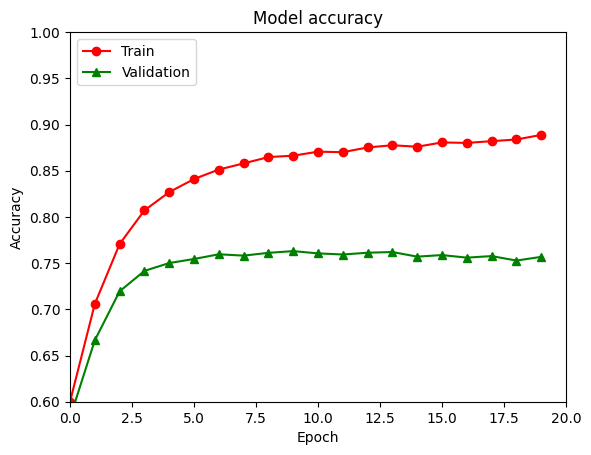

In [24]:
train_accuracy_lst = [0.6001093427287085, 0.7058984327542218, 0.7706839995140323, 0.8070708297898189, 0.8268740128781435, 0.8409974486696634, 0.8512635159761875, 0.8579151986392904,
 0.8647794921637711, 0.8662677681934151, 0.87061110436156, 0.8700643907180172, 0.8751974243712793, 0.877566516826631, 0.8759567488761998, 0.8806341878265095,
 0.8800874741829668, 0.8820009719353663, 0.8837929777669785, 0.8887741465192565]

valid_accuracy_lst = [0.5825537601749484, 0.6665046774389503, 0.719475154902199, 0.7415866844854817, 0.7500911189405904, 0.7544648280889321, 0.7595674887619973,
 0.7581095857125502, 0.7611468837322318, 0.7629692625440408, 0.7605394241282954, 0.7593245049204228, 0.7612683756530191, 0.7619973271777427, 0.7570161584254647,
 0.7587170453164864, 0.7559227311383793, 0.757623618029401, 0.7527639411979103, 0.7567731745838902]

n = len(train_accuracy_lst)
x = [i for i in range(0,n)]
y = train_accuracy_lst
z = valid_accuracy_lst
plt.plot(x,y,'ro-', x,z,'g^-')
plt.axis([0, n, 0.6, 1])
plt.ylabel('some numbers')
plt.show;
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [15]:
# MAKING LEARNING RATE LARGER

# Training arguments
train_args = TrainingArguments(
    output_dir ='./Models',
    overwrite_output_dir = True,
        # do_eval = True,
        logging_steps = 500,
        # eval_steps = 500,
        # evaluation_strategy = "steps",
        learning_rate=1e-5,  # Larger LEARNING RATE
        save_total_limit = 20,
        lr_scheduler_type='linear',
        warmup_steps = 0,
        warmup_ratio = 0.1,
        num_train_epochs=1,
        label_names = labels_list,
        logging_dir='./output/logs',
    )

In [ ]:
train_accuracy_lst_2, valid_accuracy_lst_2 = model_estimation(model, num_iter = 20)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.552100
1000,0.450000
1500,0.424800
2000,0.431100
2500,0.438300
3000,0.459200
3500,0.497300
4000,0.546000


Map: 100%|██████████████████████████████████████████████████████████████| 32924/32924 [00:03<00:00, 8899.27 examples/s]


Map: 100%|███████████████████████████████████████████████████████████████| 8231/8231 [00:00<00:00, 10331.49 examples/s]


Epoch number:  0   Train accuracy:  0.8823958206779249   Valid accuracy:  0.8079212732353298


Step,Training Loss
500,0.345100
1000,0.302600
1500,0.290400
2000,0.325200
2500,0.299400
3000,0.361900
3500,0.432700
4000,0.554600


Epoch number:  1   Train accuracy:  0.9016522901227069   Valid accuracy:  0.8115660308589479


Step,Training Loss
500,0.294900
1000,0.270600
1500,0.251300
2000,0.244000
2500,0.223500
3000,0.256200
3500,0.354500
4000,0.546800


Epoch number:  2   Train accuracy:  0.9102174705382092   Valid accuracy:  0.8178836107398858


Step,Training Loss
500,0.220800
1000,0.177800
1500,0.190800
2000,0.155600
2500,0.163600
3000,0.197100
3500,0.273600
4000,0.515400


Epoch number:  3   Train accuracy:  0.9230956141416595   Valid accuracy:  0.8267525209573563


Step,Training Loss
500,0.188700
1000,0.131500
1500,0.159800
2000,0.126800
2500,0.126800
3000,0.177200
3500,0.223400
4000,0.459600


Epoch number:  4   Train accuracy:  0.9259506742801604   Valid accuracy:  0.8228647794921637


Step,Training Loss
500,0.152100
1000,0.119100
1500,0.106200
2000,0.076800
2500,0.092600
3000,0.110900
3500,0.181800
4000,0.424000


Epoch number:  5   Train accuracy:  0.9288057344186612   Valid accuracy:  0.8222573198882275


Step,Training Loss
500,0.122900
1000,0.083700
1500,0.090500
2000,0.062700
2500,0.065900
3000,0.094500
3500,0.153600
4000,0.383400


Epoch number:  6   Train accuracy:  0.9325719839630665   Valid accuracy:  0.8200704653140566


Step,Training Loss
500,0.101300
1000,0.056600
1500,0.050200
2000,0.051800
2500,0.038400
3000,0.071200
3500,0.091700
4000,0.342000


Epoch number:  7   Train accuracy:  0.9394362774875471   Valid accuracy:  0.8218928441258656


Step,Training Loss
500,0.072300
1000,0.060700
1500,0.037700
2000,0.024700
2500,0.043900
3000,0.054700
3500,0.072200
4000,0.326200


Epoch number:  8   Train accuracy:  0.9399829911310897   Valid accuracy:  0.8177621188190985


Step,Training Loss
500,0.064400
1000,0.054500
1500,0.030400
2000,0.033900
2500,0.031700
3000,0.038600
3500,0.055900
4000,0.282000


Epoch number:  9   Train accuracy:  0.9428076782893937   Valid accuracy:  0.8172761511359494


Step,Training Loss
500,0.074600
1000,0.042000
1500,0.027300
2000,0.025000
2500,0.031600
3000,0.033800
3500,0.060000
4000,0.239400


Epoch number:  10   Train accuracy:  0.9438707325962824   Valid accuracy:  0.8195844976309076


Step,Training Loss
500,0.043500
1000,0.041100
1500,0.033600
2000,0.034500
2500,0.043400
3000,0.027600
3500,0.039800
4000,0.224000


Epoch number:  11   Train accuracy:  0.9456323654476977   Valid accuracy:  0.8210424006803547


Step,Training Loss
500,0.043100
1000,0.042200
1500,0.023700
2000,0.023200
2500,0.024900
3000,0.021500
3500,0.037200
4000,0.194200


Epoch number:  12   Train accuracy:  0.9484874255861985   Valid accuracy:  0.8201919572348438


Step,Training Loss
500,0.032500
1000,0.040800
1500,0.032000
2000,0.039500
2500,0.037200
3000,0.025800
3500,0.015000
4000,0.175000


Epoch number:  13   Train accuracy:  0.947242133398129   Valid accuracy:  0.8205564329972057


Step,Training Loss
500,0.032600
1000,0.032800
1500,0.046100
2000,0.018000
2500,0.020900
3000,0.021900
3500,0.030300
4000,0.153200


Epoch number:  14   Train accuracy:  0.947242133398129   Valid accuracy:  0.8231077633337383


Step,Training Loss
500,0.038800
1000,0.032600
1500,0.026300


In [14]:
# MAKING LEARNING RATE LOWER

# Training arguments
train_args = TrainingArguments(
    output_dir ='./Models',
    overwrite_output_dir = True,
        # do_eval = True,
        logging_steps = 500,
        # eval_steps = 500,
        # evaluation_strategy = "steps",
        learning_rate=3e-6,  # Larger LEARNING RATE
        save_total_limit = 20,
        lr_scheduler_type='linear',
        warmup_steps = 0,
        warmup_ratio = 0.1,
        num_train_epochs=1,
        label_names = labels_list,
        logging_dir='./output/logs',
    )

In [15]:
train_accuracy_lst_3, valid_accuracy_lst_3 = model_estimation(model, num_iter = 20)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.039300
1000,0.014800
1500,0.013900
2000,0.018700
2500,0.012100
3000,0.003800
3500,0.004200
4000,0.091200


Map: 100%|█████████████████████████████████████████████████████████████| 32924/32924 [00:03<00:00, 10132.82 examples/s]


Map: 100%|███████████████████████████████████████████████████████████████| 8231/8231 [00:00<00:00, 10537.69 examples/s]


Epoch number:  0   Train accuracy:  0.9474851172397035   Valid accuracy:  0.8218928441258656


Step,Training Loss
500,0.023500
1000,0.006100
1500,0.000100
2000,0.000000
2500,0.000000
3000,0.000100
3500,0.001500
4000,0.078800


Epoch number:  1   Train accuracy:  0.9490948851901349   Valid accuracy:  0.8192200218685457


Step,Training Loss
500,0.020100
1000,0.000100
1500,0.000000
2000,0.000000
2500,0.000000
3000,0.000200
3500,0.000200
4000,0.068700


Epoch number:  2   Train accuracy:  0.9504616692989916   Valid accuracy:  0.8199489733932693


Step,Training Loss
500,0.014500
1000,0.000000
1500,0.000000
2000,0.000000
2500,0.000000
3000,0.000200
3500,0.000000
4000,0.062800


Epoch number:  3   Train accuracy:  0.949580852873284   Valid accuracy:  0.817519134977524


Step,Training Loss
500,0.013000
1000,0.000000
1500,0.000000
2000,0.000100
2500,0.000000
3000,0.000000
3500,0.000000
4000,0.056400


Epoch number:  4   Train accuracy:  0.9490037662495444   Valid accuracy:  0.8173976430567367


Step,Training Loss
500,0.012700
1000,0.000000
1500,0.000000
2000,0.000700
2500,0.000000
3000,0.000000
3500,0.000000
4000,0.047800


Epoch number:  5   Train accuracy:  0.9481229498238367   Valid accuracy:  0.8177621188190985


Step,Training Loss
500,0.011900
1000,0.000000
1500,0.000000
2000,0.000000
2500,0.000000
3000,0.000000
3500,0.000000
4000,0.043600


Epoch number:  6   Train accuracy:  0.9510083829425343   Valid accuracy:  0.8205564329972057


Step,Training Loss
500,0.009100
1000,0.000000
1500,0.000000
2000,0.002600
2500,0.001900
3000,0.000100
3500,0.000000
4000,0.041000


Epoch number:  7   Train accuracy:  0.9510995018831248   Valid accuracy:  0.8214068764427166


Step,Training Loss
500,0.008600
1000,0.000000
1500,0.000000
2000,0.000000
2500,0.000000
3000,0.000000
3500,0.000000
4000,0.035800


Epoch number:  8   Train accuracy:  0.9522840481108006   Valid accuracy:  0.8232292552545256


Step,Training Loss
500,0.006800
1000,0.000000
1500,0.000000
2000,0.000000
2500,0.002600
3000,0.000000
3500,0.000000
4000,0.036900


Epoch number:  9   Train accuracy:  0.9521018102296197   Valid accuracy:  0.8216498602842911


Step,Training Loss
500,0.007100
1000,0.000000
1500,0.000000
2000,0.000000
2500,0.000000
3000,0.000000
3500,0.000000
4000,0.028000


Epoch number:  10   Train accuracy:  0.954713886526546   Valid accuracy:  0.8239582067792491


Step,Training Loss
500,0.005700
1000,0.000000
1500,0.000000
2000,0.000000
2500,0.000000
3000,0.000000
3500,0.000000
4000,0.030100


Epoch number:  11   Train accuracy:  0.9537723241404447   Valid accuracy:  0.8249301421455473


Step,Training Loss
500,0.005600
1000,0.000000
1500,0.000000
2000,0.000000
2500,0.000000
3000,0.000000
3500,0.000000
4000,0.021600


Epoch number:  12   Train accuracy:  0.9569311140809136   Valid accuracy:  0.8272384886405054


Step,Training Loss
500,0.003100
1000,0.000000
1500,0.000000
2000,0.000000
2500,0.000000
3000,0.000000
3500,0.000000
4000,0.020400


Epoch number:  13   Train accuracy:  0.955382092090876   Valid accuracy:  0.8244441744623983


Step,Training Loss
500,0.004800
1000,0.000000
1500,0.000000
2000,0.000000
2500,0.000000
3000,0.000000
3500,0.000000
4000,0.019400


Epoch number:  14   Train accuracy:  0.957204470902685   Valid accuracy:  0.8273599805612927


Step,Training Loss
500,0.002100
1000,0.000000
1500,0.000000
2000,0.000000
2500,0.000000
3000,0.000000
3500,0.000000
4000,0.017200


Epoch number:  15   Train accuracy:  0.9574778277244563   Valid accuracy:  0.8274814724820799


Step,Training Loss
500,0.003000
1000,0.000000
1500,0.000000
2000,0.000000
2500,0.000000
3000,0.000000
3500,0.000000
4000,0.017700


Epoch number:  16   Train accuracy:  0.9578423034868181   Valid accuracy:  0.8288178836107399


Step,Training Loss
500,0.001700
1000,0.000000
1500,0.000000
2000,0.000000
2500,0.000000
3000,0.000000
3500,0.000000
4000,0.015400


Epoch number:  17   Train accuracy:  0.9557465678532377   Valid accuracy:  0.8263880451949945


Step,Training Loss
500,0.002400
1000,0.000000
1500,0.000000
2000,0.000000
2500,0.000000
3000,0.000000
3500,0.000000
4000,0.015400


Epoch number:  18   Train accuracy:  0.9590572226946908   Valid accuracy:  0.8297898189770381


Step,Training Loss
500,0.001400
1000,0.000000
1500,0.000000
2000,0.000000
2500,0.000000
3000,0.000000
3500,0.000000
4000,0.015700


Epoch number:  19   Train accuracy:  0.957204470902685   Valid accuracy:  0.8284534078483781


In [16]:
train_accuracy_lst_3

[0.9474851172397035,
 0.9490948851901349,
 0.9504616692989916,
 0.949580852873284,
 0.9490037662495444,
 0.9481229498238367,
 0.9510083829425343,
 0.9510995018831248,
 0.9522840481108006,
 0.9521018102296197,
 0.954713886526546,
 0.9537723241404447,
 0.9569311140809136,
 0.955382092090876,
 0.957204470902685,
 0.9574778277244563,
 0.9578423034868181,
 0.9557465678532377,
 0.9590572226946908,
 0.957204470902685]

In [17]:
valid_accuracy_lst_3

[0.8218928441258656,
 0.8192200218685457,
 0.8199489733932693,
 0.817519134977524,
 0.8173976430567367,
 0.8177621188190985,
 0.8205564329972057,
 0.8214068764427166,
 0.8232292552545256,
 0.8216498602842911,
 0.8239582067792491,
 0.8249301421455473,
 0.8272384886405054,
 0.8244441744623983,
 0.8273599805612927,
 0.8274814724820799,
 0.8288178836107399,
 0.8263880451949945,
 0.8297898189770381,
 0.8284534078483781]

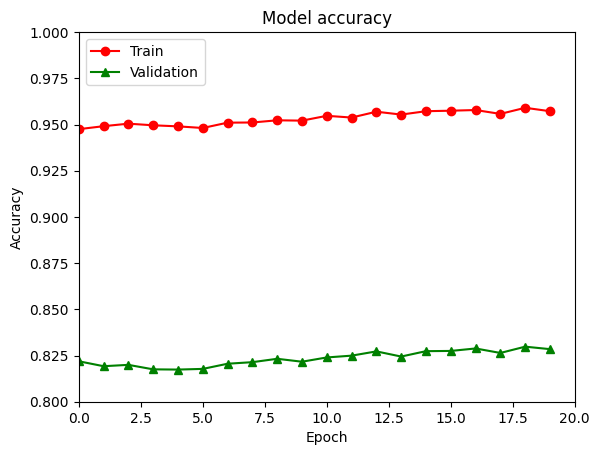

In [28]:
# Plot training & validation accuracy values

import matplotlib.pyplot as plt

n = len(train_accuracy_lst_3)
x = [i for i in range(0,n)]
y = train_accuracy_lst_3
z = valid_accuracy_lst_3
plt.plot(x,y,'ro-', x,z,'g^-')
plt.axis([0, n, 0.8, 1])
plt.ylabel('some numbers')
plt.show;
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [25]:
model = AutoModelForSequenceClassification.from_pretrained('./Models/checkpoint-20500')
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Loading the pretrained 'bert-base-uncased' model (default parameters of optimization, about 15 optimization epochs).

In [26]:
train_accuracy_lst_4, valid_accuracy_lst_4 = model_estimation(model, num_iter = 1)

Step,Training Loss
500,0.125300
1000,0.114400
1500,0.115600
2000,0.125400
2500,0.101600
3000,0.107800
3500,0.094400
4000,0.116800


Epoch number:  0   Train accuracy:  0.9803486818126594   Valid accuracy:  0.871097072044709


In [ ]:
# The best predictions were recieved for the model trained with dafault parameters!
# We shall take this model to make predictions for test sampling.

In [30]:
model = AutoModelForSequenceClassification.from_pretrained('./Models/checkpoint-4000')
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [31]:
trainer = Trainer(model=model, 
            args=train_args, 
            data_collator = data_collator, 
            train_dataset = tokenizer_data['train'],
            eval_dataset = tokenizer_data['test'],)

In [32]:
test_predicted_labels = making_predictions(trainer, test_dataset_X, 'test')

Map: 100%|████████████████████████████████████████████████████████████████| 3798/3798 [00:00<00:00, 5285.03 examples/s]


In [33]:
# Test predictions calculation

voc_rev = {0:'Neutral',1:'Positive',2:'Negative', 3:'Extremely Positive', 4:'Extremely Negative'}

predictions = []
for i in range(len(test_predicted_labels)):
    x = test_predicted_labels[i]
    predictions.append(voc_rev[x])

preds = pd.DataFrame(predictions)
preds
preds.to_csv(f'predictions.csv', index=None, header=False)

In [35]:
preds.tail()

,0
3793,Positive
3794,Negative
3795,Neutral
3796,Extremely Negative
3797,Extremely Positive
